1. Data set yang digunakan adalah diabetes (https://www.kaggle.com/datasets/cgyputra/bmri-jk-stock-data)

In [15]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

df = pd.read_csv('/content/BMRI.JK.csv')
trading_days = 252
np.random.seed(42)
df


,Date,Close,High,Low,Open,Volume
0,2003-07-14,91.39,94.07,83.32,83.32,396676086
1,2003-07-15,91.39,96.76,91.39,94.07,841825534
2,2003-07-16,88.70,91.39,88.70,91.39,147014628
3,2003-07-17,91.39,91.39,88.70,88.70,222191824
4,2003-07-18,91.39,91.39,88.70,88.70,82279783
...,...,...,...,...,...,...
5335,2025-01-21,6050.00,6175.00,6025.00,6100.00,115355900
5336,2025-01-22,6150.00,6200.00,6100.00,6150.00,117929800
5337,2025-01-23,6175.00,6300.00,6175.00,6200.00,120893700
5338,2025-01-24,6125.00,6250.00,6125.00,6250.00,96161800


Data Cleaning & Data Preprocessin

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5340 entries, 0 to 5339
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5340 non-null   object 
 1   Close   5340 non-null   float64
 2   High    5340 non-null   float64
 3   Low     5340 non-null   float64
 4   Open    5340 non-null   float64
 5   Volume  5340 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 250.4+ KB


In [ ]:
df.isna().sum()

,0
Date,0
Close,0
High,0
Low,0
Open,0
Volume,0


In [ ]:
check_duplicate = df.duplicated().sum()

print(f"Jumlah data yang duplikat = {check_duplicate}")

Jumlah data yang duplikat = 0


In [ ]:
price_candidates = ['Close','close','Adj Close','Adj_Close','close_price','Close/Last']
price_col = next((c for c in price_candidates if c in df.columns), None)
if price_col is None:
    # fallback: ambil kolom numeric terakhir
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if len(numeric_cols)==0:
        raise ValueError("Tidak ada kolom numeric untuk harga. Pastikan ada kolom Close.")
    price_col = numeric_cols[-1]

In [ ]:
date_candidates = ['Date','date','DATE']
date_col = next((c for c in date_candidates if c in df.columns), None)
if date_col is None:
    # try infer
    possible = [c for c in df.columns if 'date' in c.lower()]
    date_col = possible[0] if possible else None

if date_col is not None:
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df = df.sort_values(date_col).reset_index(drop=True)
    if date_col is not None:
        df = df.set_index(date_col)
else:
    # keep numeric index order
    df = df.reset_index(drop=True)

df = df.rename(columns={price_col: 'Close'})
df = df[['Close']].copy()

Transformasi data, Exploratory Data Analysis, Risk & Volatility Modeling

In [ ]:
df['Return'] = df['Close'].pct_change()
df['LogReturn'] = np.log(df['Close'] / df['Close'].shift(1))

# basic stats
stats = df[['Close','Return','LogReturn']].describe().T
mean_daily_return = df['Return'].mean()
annual_return = (1 + mean_daily_return) ** trading_days - 1
annual_volatility = df['LogReturn'].std() * np.sqrt(trading_days)

# rolling volatility (annualized)
df['Vol_21d'] = df['LogReturn'].rolling(21).std() * np.sqrt(trading_days)
df['Vol_63d'] = df['LogReturn'].rolling(63).std() * np.sqrt(trading_days)

# EWMA vol (RiskMetrics lambda=0.94)
lam = 0.94
logr = df['LogReturn'].dropna()
s2 = None
ewma_var = []
for r in logr:
    if s2 is None:
        s2 = r**2
    else:
        s2 = lam * s2 + (1 - lam) * (r**2)
    ewma_var.append(s2)
ewma_var = pd.Series(ewma_var, index=logr.index)
df.loc[ewma_var.index, 'EWMA_vol_annualized'] = np.sqrt(ewma_var) * np.sqrt(trading_days)



In [ ]:
def historical_var(returns, alpha=0.05, horizon=1, n_boot=10000):
    # returns: series of daily returns (not log returns)
    r = returns.dropna().values
    if horizon == 1:
        return -np.percentile(r, alpha*100)
    # bootstrap sums for horizon
    n = n_boot
    idx = np.random.randint(0, len(r), size=(n, horizon))
    sim = r[idx].sum(axis=1)
    return -np.percentile(sim, alpha*100)

def parametric_var(returns, alpha=0.05, horizon=1):
    mu = returns.mean()
    sigma = returns.std()
    z = norm.ppf(alpha)
    # VaR as positive loss
    return -(horizon*mu + z * np.sqrt(horizon) * sigma)

# compute VaR
ret = df['Return']
VaR_hist_95_1d = historical_var(ret, 0.05, 1)
VaR_hist_99_1d = historical_var(ret, 0.01, 1)
VaR_param_95_1d = parametric_var(ret, 0.05, 1)
VaR_param_99_1d = parametric_var(ret, 0.01, 1)

VaR_hist_95_10d = historical_var(ret, 0.05, 10)
VaR_hist_99_10d = historical_var(ret, 0.01, 10)
VaR_param_95_10d = parametric_var(ret, 0.05, 10)
VaR_param_99_10d = parametric_var(ret, 0.01, 10)

var_table = pd.DataFrame({
    'Method': ['Historical','Historical','Parametric','Parametric','Historical(10d)','Historical(10d)','Parametric(10d)','Parametric(10d)'],
    'Alpha': [0.05,0.01,0.05,0.01,0.05,0.01,0.05,0.01],
    'Horizon_days':[1,1,1,1,10,10,10,10],
    'VaR': [VaR_hist_95_1d, VaR_hist_99_1d, VaR_param_95_1d, VaR_param_99_1d, VaR_hist_95_10d, VaR_hist_99_10d, VaR_param_95_10d, VaR_param_99_10d]
})

In [ ]:
S0 = df['Close'].dropna().iloc[-1]
mu = df['LogReturn'].dropna().mean()
sigma = df['LogReturn'].dropna().std()
n_sim = 10000
horizon = 10
sim_ending = []
for i in range(n_sim):
    # simulate daily log-returns with drift (mu - 0.5 sigma^2)
    rand = np.random.normal(loc=(mu - 0.5 * sigma**2), scale=sigma, size=horizon)
    log_S = np.log(S0) + rand.cumsum()
    S_T = np.exp(log_S[-1])
    sim_ending.append((S_T - S0) / S0)
sim_ending = np.array(sim_ending)
mc_var_95_10d = -np.percentile(sim_ending, 5)
mc_var_99_10d = -np.percentile(sim_ending, 1)

In [ ]:
print("=== DATA INFO ===")
print(f"Observations: {len(df)}")
if isinstance(df.index, pd.DatetimeIndex):
    print(f"Date range: {df.index.min().date()} to {df.index.max().date()}")
print(f"Last Close: {S0:.2f}")
print()
print("=== SUMMARY STATS (Close, Return, LogReturn) ===")
print(stats[['mean','std','min','25%','50%','75%','max']])
print()
print("Annualized estimates:")
print(f" - Annual return (est): {annual_return:.4%}")
print(f" - Annual volatility (est): {annual_volatility:.4%}")
print()
print("=== VaR SUMMARY ===")
print(var_table.to_string(index=False))
print()
print(f"Monte Carlo (GBM) 10-day VaR 95%: {mc_var_95_10d:.4%}, 99%: {mc_var_99_10d:.4%}")

=== DATA INFO ===
Observations: 5340
Date range: 2003-07-14 to 2025-01-30
Last Close: 6100.00

=== SUMMARY STATS (Close, Return, LogReturn) ===
                  mean          std        min         25%       50%  \
Close      1871.846300  1661.375424  80.640000  428.580000  1541.485   
Return        0.001075     0.024068  -0.145166   -0.010986     0.000   
LogReturn     0.000787     0.023960  -0.156847   -0.011047     0.000   

                   75%          max  
Close      2696.290000  7450.000000  
Return        0.012421     0.199989  
LogReturn     0.012344     0.182313  

Annualized estimates:
 - Annual return (est): 31.0931%
 - Annual volatility (est): 38.0354%

=== VaR SUMMARY ===
         Method  Alpha  Horizon_days      VaR
     Historical   0.05             1 0.034879
     Historical   0.01             1 0.064933
     Parametric   0.05             1 0.038513
     Parametric   0.01             1 0.054915
Historical(10d)   0.05            10 0.113362
Historical(10d)   0.01   

Diagram grafik time series harga penutupan (Close Price) saham Bank Mandiri (BMRI) dari tahun 2003 sampai 2024.

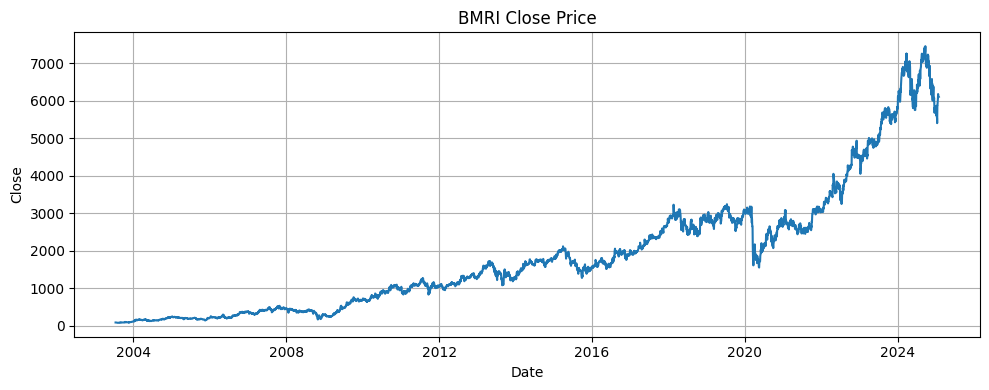

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(df['Close'])
plt.title('BMRI Close Price')
plt.xlabel('Date')
plt.ylabel('Close')
plt.grid(True)
plt.tight_layout()
plt.show()

grafik estimasi volatilitas tahunan (annualized volatility estimates) dari saham BMRI.

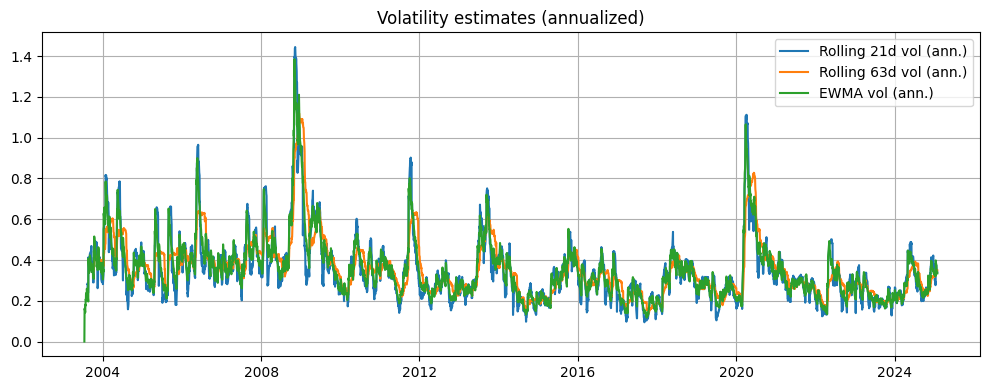

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(df['LogReturn'].rolling(21).std() * np.sqrt(trading_days), label='Rolling 21d vol (ann.)')
plt.plot(df['Vol_63d'], label='Rolling 63d vol (ann.)')
plt.plot(df['EWMA_vol_annualized'], label='EWMA vol (ann.)')
plt.legend()
plt.title('Volatility estimates (annualized)')
plt.grid(True)
plt.tight_layout()
plt.show()


histogram distribusi return 10 hari hasil simulasi Monte Carlo

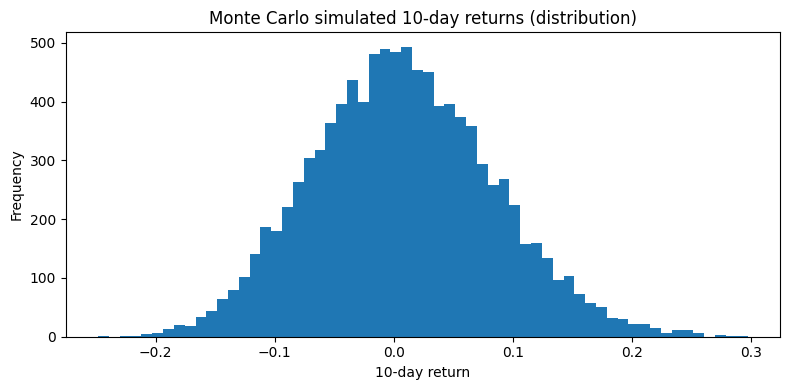

In [ ]:
plt.figure(figsize=(8,4))
plt.hist(sim_ending, bins=60)
plt.title('Monte Carlo simulated 10-day returns (distribution)')
plt.xlabel('10-day return')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()